# Imports

In [51]:
import utils as lib

import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

# Data Preprocessing

#### 1. Read the Data and collect informations

In [52]:
# Load the CSV file "dataset.csv" using semicolon as the delimiter and ISO-8859-1 encoding
data = pd.read_csv("dataset.csv", sep=';', encoding='ISO-8859-1')

# Display an overview of the first five rows of the loaded data
data.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71,3,3,2,right ocular pain,1,1,2,...,36.6,100,2,Corneal abrasion,1,4,2,86,5,1
1,1,1,56,12,3,2,right forearm burn,1,1,2,...,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,"3,95",1
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2,...,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,1,1
3,1,2,71,8,1,1,ascites tapping,1,1,3,...,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,"9,83",1
4,1,2,58,4,3,1,"distension, abd",1,1,3,...,36.5,NaN,4,Ascites,1,5,8,109,"6,6",1


In [53]:
# Display summary information about the loaded data, including column data types and non-null counts
data.info()
print("\nsize of dataset: " + str(data.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Group                     1267 non-null   int64 
 1   Sex                       1267 non-null   int64 
 2   Age                       1267 non-null   int64 
 3   Patients number per hour  1267 non-null   int64 
 4   Arrival mode              1267 non-null   int64 
 5   Injury                    1267 non-null   int64 
 6   Chief_complain            1267 non-null   object
 7   Mental                    1267 non-null   int64 
 8   Pain                      1267 non-null   int64 
 9   NRS_pain                  1267 non-null   object
 10  SBP                       1267 non-null   object
 11  DBP                       1267 non-null   object
 12  HR                        1267 non-null   object
 13  RR                        1267 non-null   object
 14  BT                      

In [54]:
# Generate descriptive statistics of the data, including percentiles, for each column
# The .T at the end transposes the result for better readability
data.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
Group,1267.0,1.456985,0.498343,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.00,2.0
Sex,1267.0,1.521705,0.499726,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.00,2.0
Age,1267.0,54.423836,19.725033,16.0,25.0,37.0,57.0,71.0,79.0,82.0,88.00,96.0
Patients number per hour,1267.0,7.519337,3.160563,1.0,3.0,5.0,7.0,10.0,12.0,13.0,15.00,17.0
Arrival mode,1267.0,2.820837,0.807904,1.0,2.0,2.0,3.0,3.0,4.0,4.0,5.00,7.0
Injury,1267.0,1.192581,0.394482,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.00,2.0
Mental,1267.0,1.105762,0.447768,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.34,4.0
Pain,1267.0,0.563536,0.496143,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.00,1.0
KTAS_RN,1267.0,3.335438,0.885391,1.0,2.0,3.0,3.0,4.0,4.0,5.0,5.00,5.0
Disposition,1267.0,1.609313,1.157983,1.0,1.0,1.0,1.0,2.0,2.0,4.0,7.00,7.0


In [55]:
# Check if there are any missing values (null values) in the loaded data
# Returns True if any missing value exists, and False otherwise
data.isnull().values.any()

True

#### 2. Feature Overview

##### Distribution

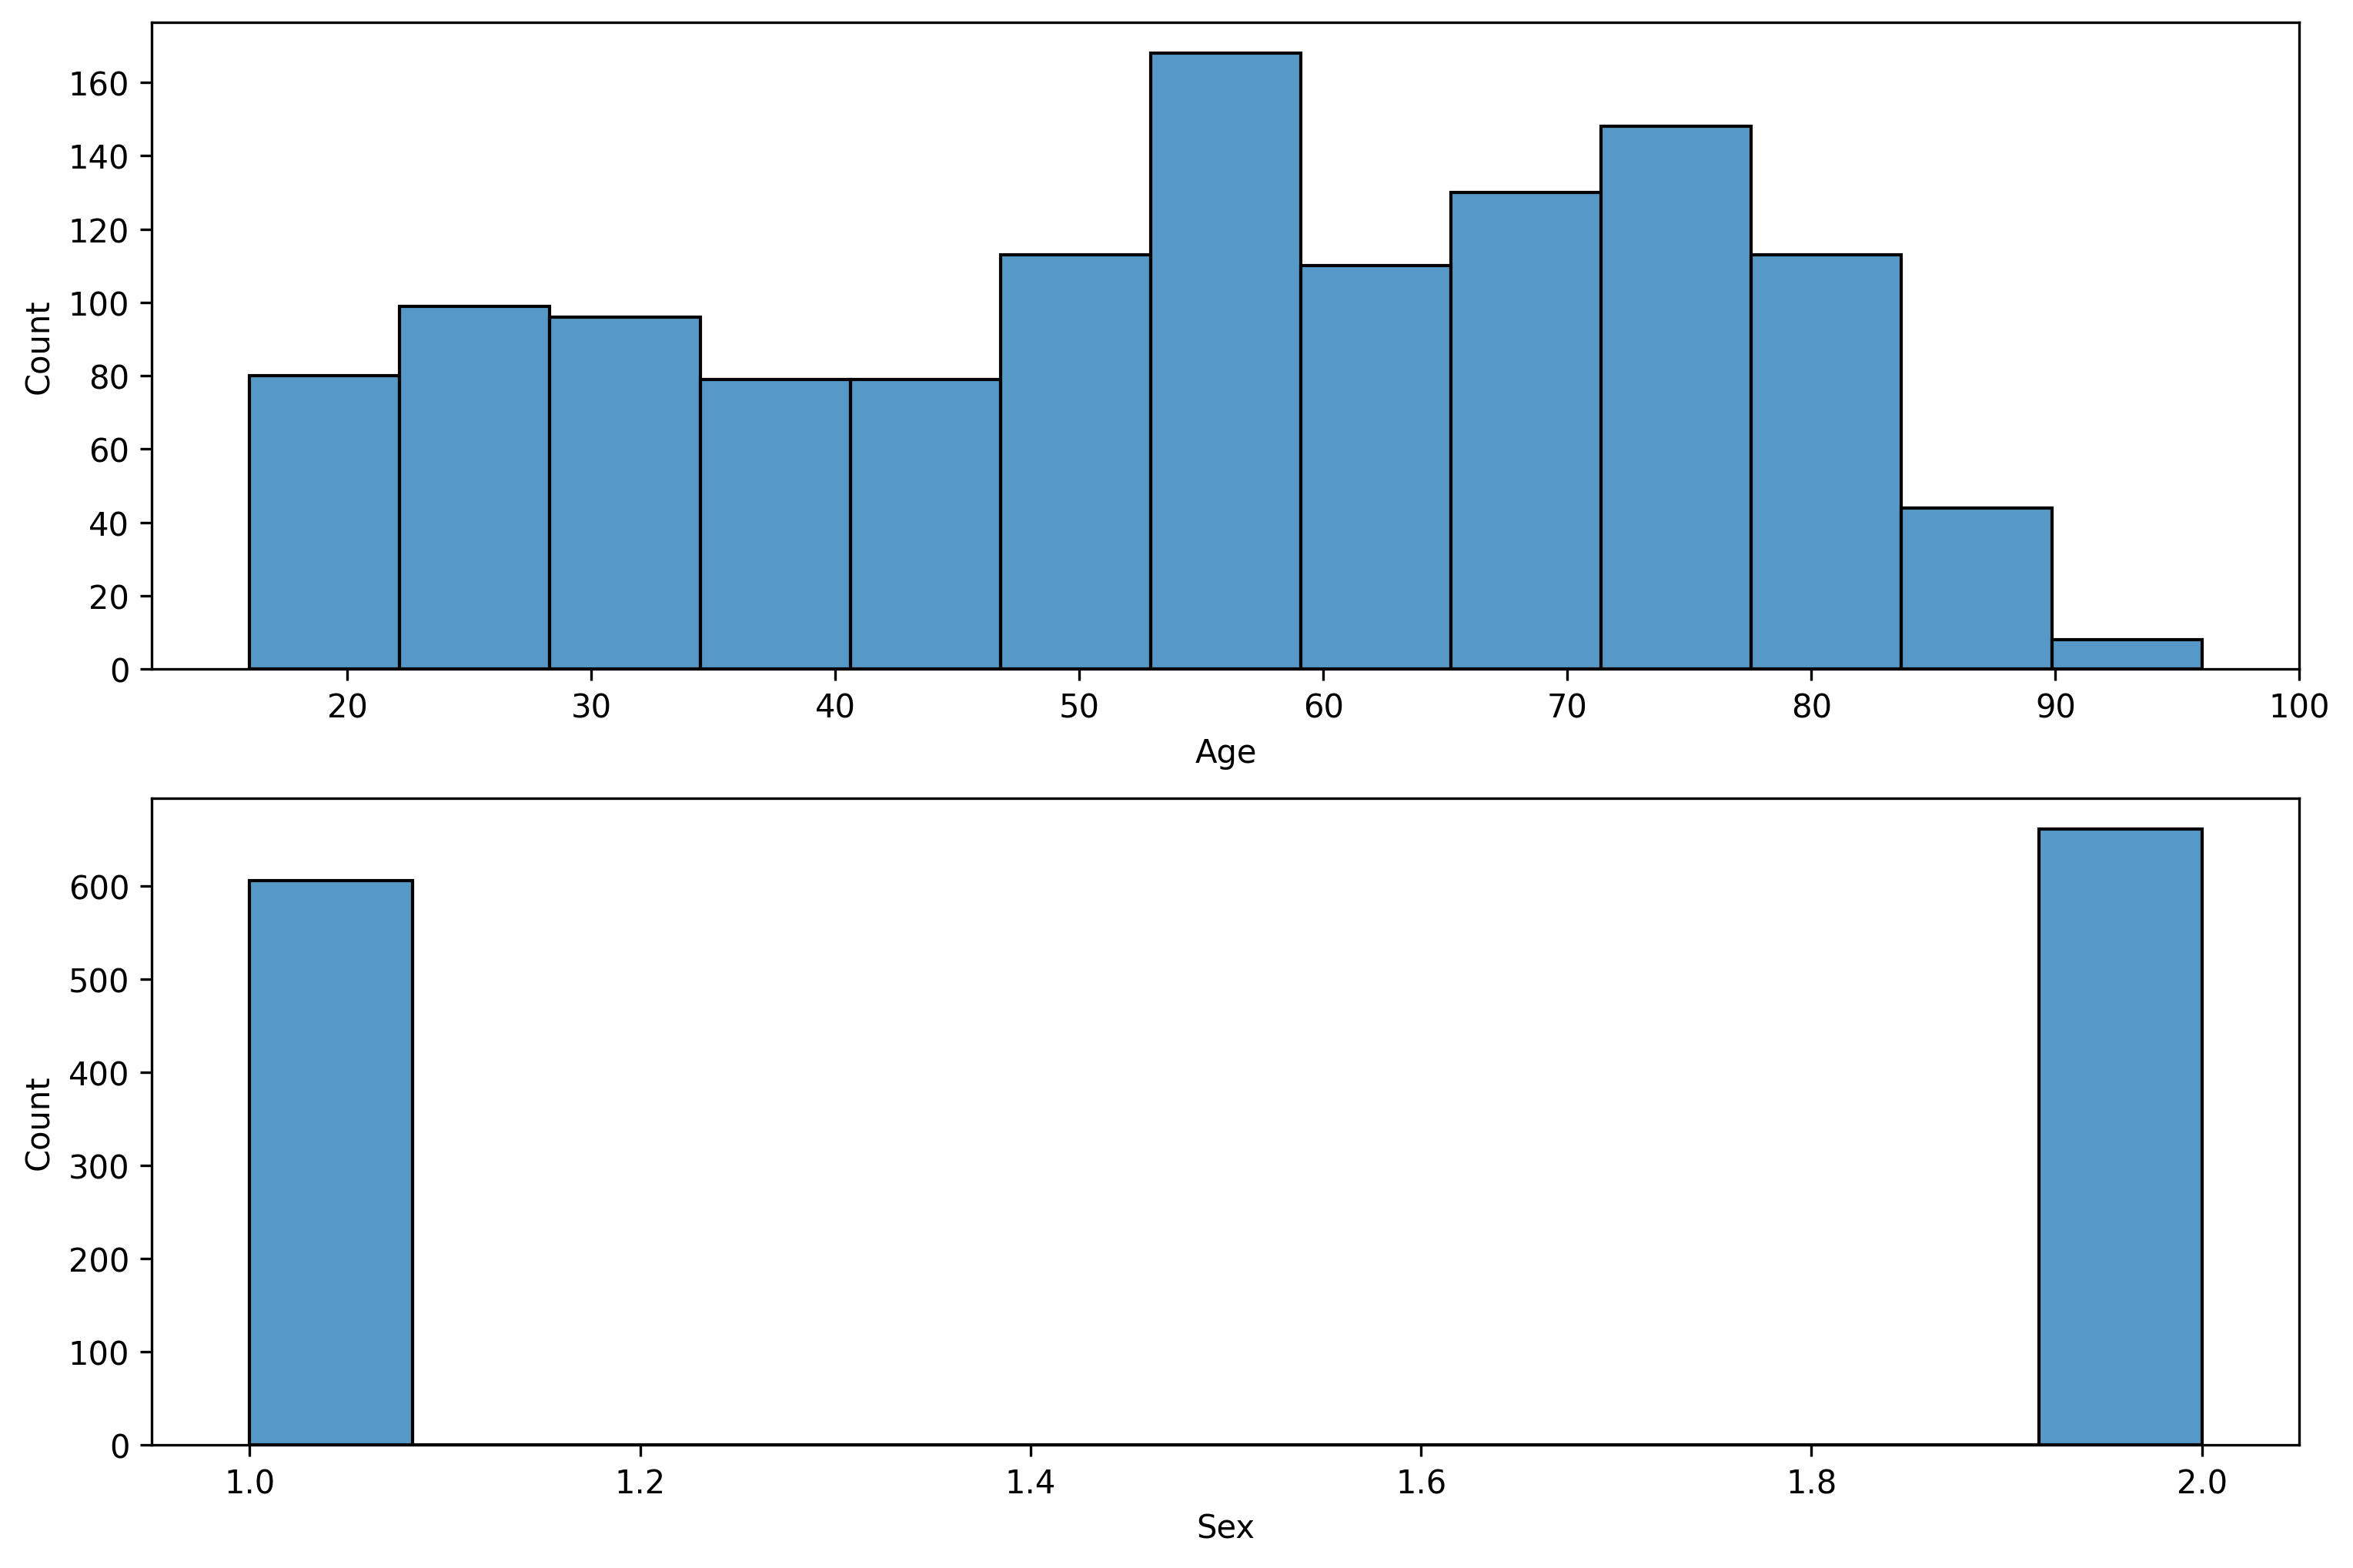

In [56]:
# List of feature names you want to visualize
feature_names = ["Age", "Sex"]

# Visualizes the distribution of specified features in the given DataFrame using histograms.
lib.show_distribution(data, feature_names=feature_names)

#### 3. Missing Value Analysis

Der Datensatz muss auf fehlende Daten überprüft werden, da diese die Qualität des Modells stark beeinträchtigen können.

Dazu müssen Features mit fehlenden Werten zuerst identifiziert und die Lücken anschließend mit einer selbst gewählten Methode 
gefüllt werden.

                 n_miss  ratio
Saturation          697  55.01
NRS_pain            556  43.88
DBP                  29   2.29
SBP                  25   1.97
RR                   22   1.74
Chief_complain       21   1.66
HR                   20   1.58
BT                   18   1.42
Diagnosis in ED       2   0.16


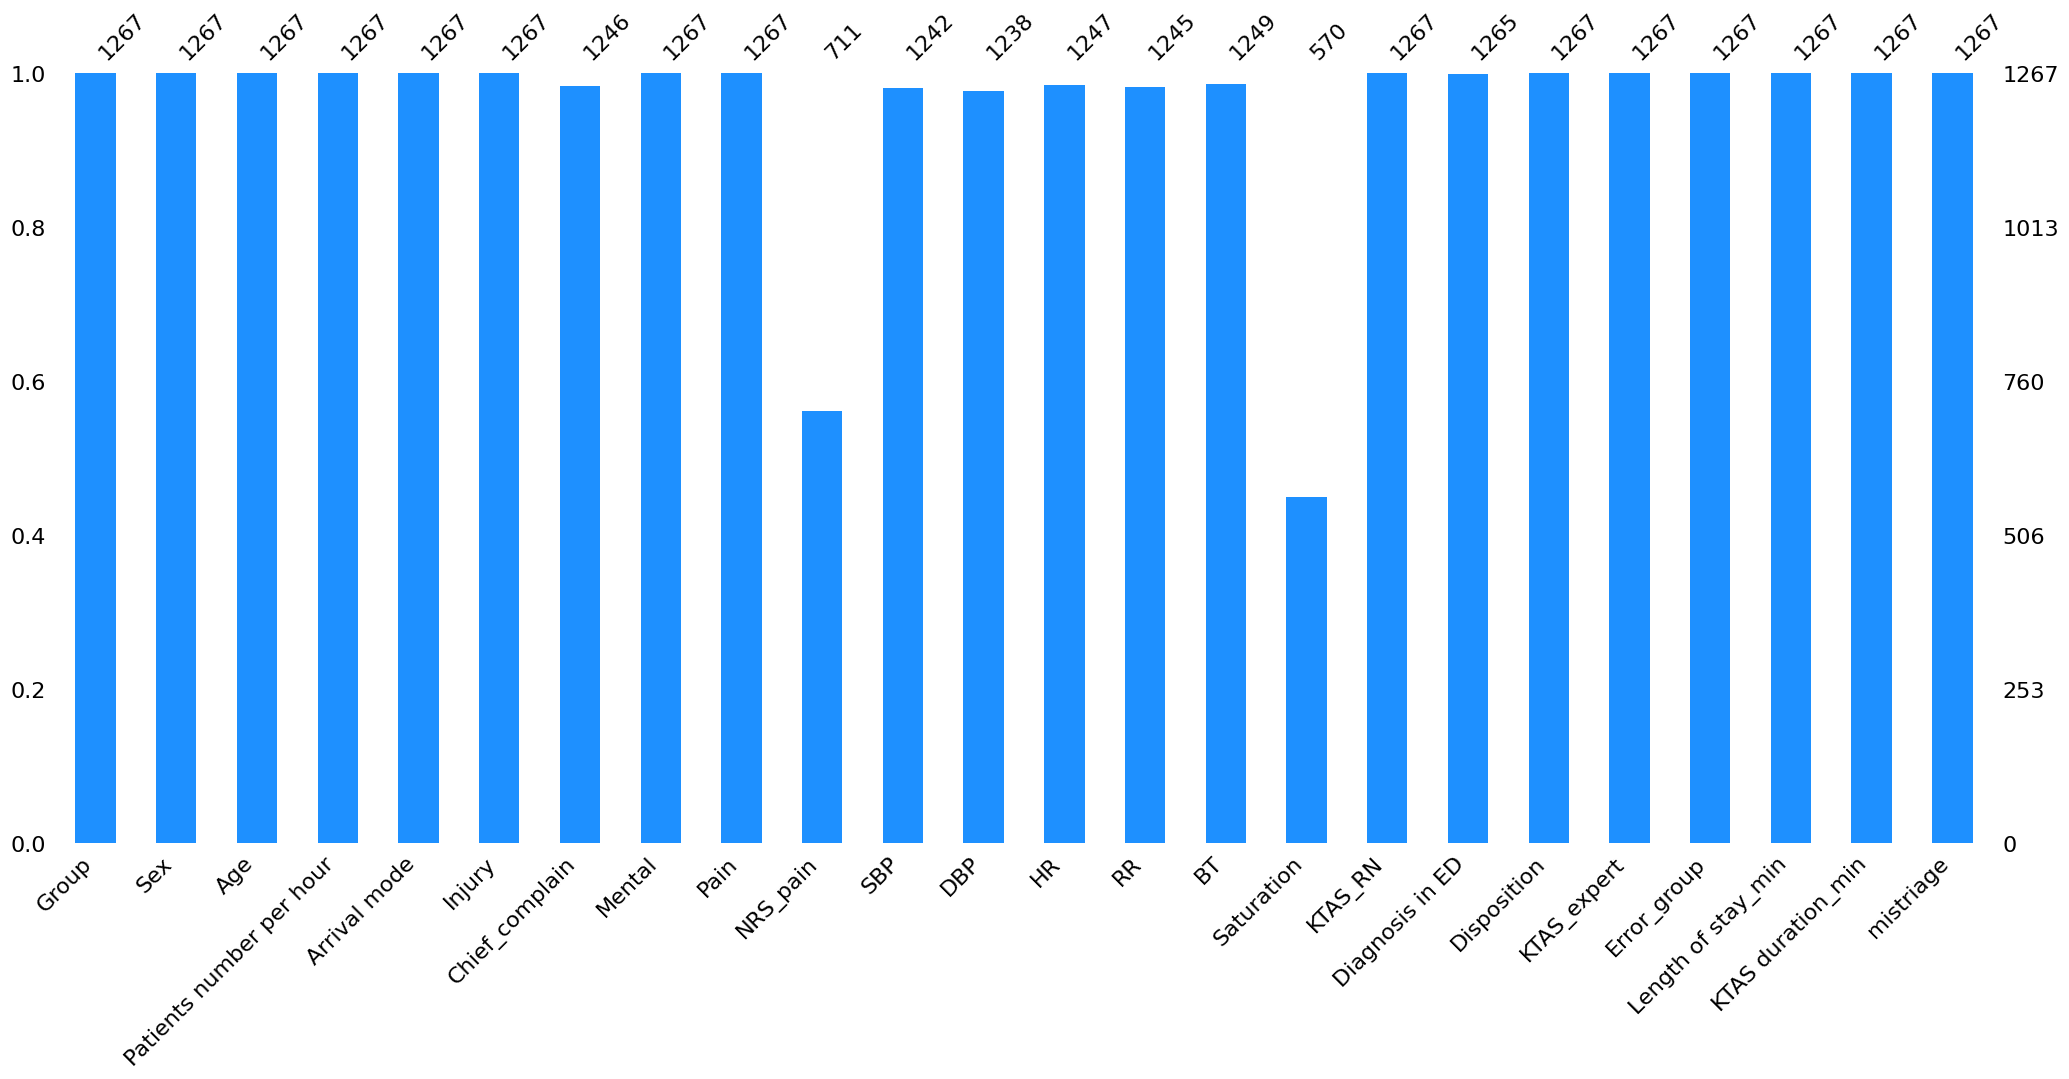

In [57]:
# List of columns to replace missing values in
columns = ['Group', 'Age', 'Patients number per hour', 'Arrival mode', 'Injury', 'Chief_complain', 'Mental', 
           'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED',
           'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min', 'KTAS duration_min', 'mistriage']

# This function generates a summary table of missing values for each column in the DataFrame.
missing_values = lib.identify_missing_values(data, columns)

# Display a bar chart visualizing missing values
show = True
if show: msno.bar(data, color="dodgerblue")

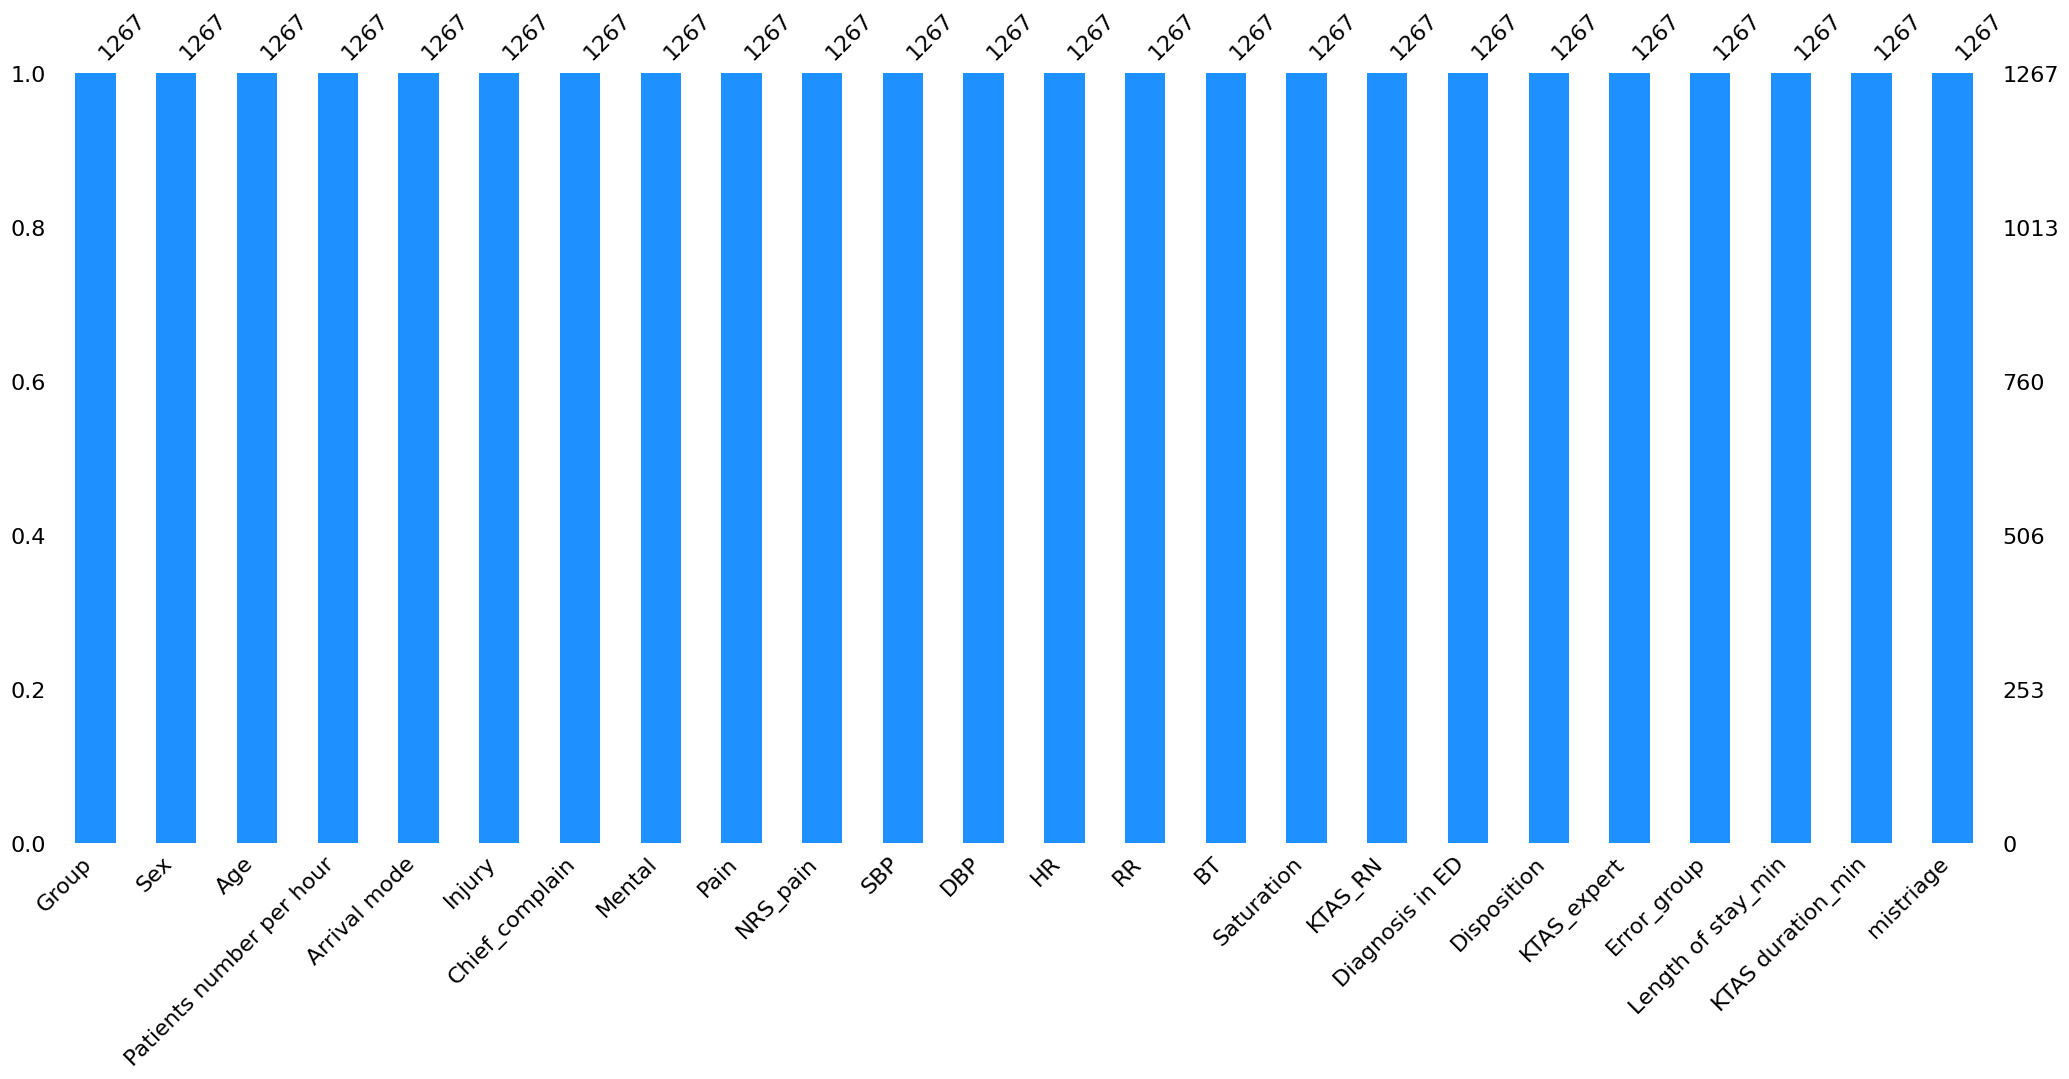

In [58]:
# choose 'delete' for deleting the feature with missing values
# 'mean' for the mean value (numeric) and the most common value (categoric)
# 'mode' for the most common value for every feature 
# 'estimate' for Estimation of probable value based on the entire sample
missing_values_strategy = 'mode' 
data, columns = lib.handle_missing_data(data, columns, missing_values_strategy, missing_values)

# Create a bar chart visualization of missing values
if show: msno.bar(data, color="dodgerblue")

# Check if there are still any missing values in the entire DataFrame
data.isnull().values.any()

# Convert 'object' data types to 'float' if the column contains numeric values
lib.transformObjectToFloat(data)

#### 4. Feature Enginnering

##### Check and Remove Outliers

Bei der Datenaufbereitung ist es wichtig, Ausreißer im Datensatz zu finden und so zu ändern, dass diese das Modell nicht negativ beeinflussen. Mit der Methode has_outliers(), werden die Features mit der Anzahl der Ausreißer identifiziert und zurückgegeben. 

In [59]:
# Detect and print columns with potential outliers in the 'data' DataFrame
outlier_column = lib.has_outliers(data, columns)

Mental : 13
BT : 2
Saturation : 27
Length of stay_min : 19


In [60]:
# replace outliers with the calculated thresholds.
for i in outlier_column:
    lib.replace_with_thresholds(data,i)

# Check for outliers again in the modified 'data' DataFrame
lib.has_outliers(data, columns)

[]

##### MinMaxScaler for Numerical Features

Eine gängige Methode ist numerische Daten zu standardisieren oder zu scalieren, da die meisten Algorithmen distanzbasierend arbeiten und sonst der Einfluss von Features mit großen Scalen (bspw. Größe in mm) gegenüber Features mit kleineren Scalen (bspw. Alter) überschätzt wird. 

Eine Methode ist bspw. der `MinMaxScaler(min, max)`, der die Werte des Features auf das Interval [min, max] scaliert.

Eine weitere Methode ist der `StandardScaler()`, der Daten so transformiert, dass diese einen Mittelwert von 0 und eine Standardabweichung von 1 haben.

In [61]:
# choose MinMaxScaler or StandardScaler
scaler = MinMaxScaler()
#scaler = StandardScaler()

# Select columns with numeric data types and apply MinMaxScaler to the selected numerical columns
numerical_columns = data.select_dtypes(include=[np.number]).columns 
numerical_columns = numerical_columns.drop('mistriage') # don't transform the mistriage value beacuse its already [0,1,2]

data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

##### One-Hot Encoding for Categorical Features

Kategorische Daten, also Wörter und Zeichenketten, müssen ebenfalls für das Modell aufbereitet werden. 

Eine gängige Methode hierfür ist das ` One-Hot Encoding `. Sie transformiert kategorische Features zu einem binären Vektor.

In [62]:
# Apply one-hot encoding to categorical columns with categorical values
data, columns = lib.OneHotEncoder(data, columns)

['Group', 'Age', 'Patients number per hour', 'Arrival mode', 'Injury', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min', 'KTAS duration_min', 'mistriage']


#### 5. Imbalanced Data


Das Bearbeiten unausgeglichener Daten (imbalanced data) ist wichtig, da diese dazu führen können, dass ein Modell eine Verzerrung in Richtung der häufigeren Klasse aufweist und die Leistung des Modells für die weniger häufige Klasse beeinträchtigt wird. 

Ist die Zielvariable diskret, kann `Oversampling`, `Undersampling` oder `Smote` verwendet werden.

Ist die Zielvariable kontinuierlich, muss `Bootstrapping` verwendet werden.

Daraus resultiert folgende Vorgehensweise: Zielvariable bestimmen - überlegen ob kontinuierlich oder diskret - Methode bestimmen

In [63]:
# choose your strategy for handling the imbalanced data
# 'oversampling'
# 'undersampling'
# 'smote'
# 'bootstrapping'

target = 'mistriage' # choose the target feature

imbalanced_strategy = 'oversampling'
n_iterations = 10  # Needed for bootstrapping

data = lib.balance_data(data, imbalanced_strategy, n_iterations, target)

Oversampling


#### 6. Feature Selection

Die Feature Selection ist wichtig, um die Menge der Eingabevariablen für das Modell zu reduzieren. 

Es sollen nur relevante Daten verwendet und Rauschen in den Daten beseitigt werden.

In [64]:
# choose one of the two following trategys for the feature selection: 'Lasso regression' or 'PCA'

selection_strategy = 'Lasso'  # choose 'PCA' or 'Lasso'

alpha = 0.001               # Needed for Lasso regression
n_features = 20             # Needed for PCA: number of features

ready_data = lib.select_the_features(data, selection_strategy, alpha, n_features, target)
ready_data.head()

,Sex,Age,Arrival mode,Injury,Mental,Pain,NRS_pain,SBP,RR,BT,...,Diagnosis in ED_Suicide tendency,Diagnosis in ED_Syncope,Diagnosis in ED_Transient global amnesia,Diagnosis in ED_Traumatic subdural hemorrhage without open intracranial wound,Diagnosis in ED_Unspecified abdominal pain,Diagnosis in ED_Unstable angina,Diagnosis in ED_Upper abdominal pain. unspecified,Diagnosis in ED_Ureter stone,Diagnosis in ED_Vomiting,mistriage
0,1.0,0.6875,0.333333,1.0,0.0,1.0,0.111111,0.488889,0.250,0.336842,...,False,False,False,False,False,False,False,False,False,1
1,0.0,0.5000,0.333333,1.0,0.0,1.0,0.111111,0.386667,0.375,0.315789,...,False,False,False,False,False,False,False,False,False,1
2,0.0,0.6500,0.166667,1.0,0.0,1.0,0.111111,0.355556,0.375,0.336842,...,False,False,False,False,False,False,False,False,False,1
3,1.0,0.6875,0.000000,0.0,0.0,1.0,0.222222,0.395556,0.375,0.315789,...,False,False,False,False,False,False,False,False,False,1
4,1.0,0.5250,0.333333,0.0,0.0,1.0,0.222222,0.182222,0.250,0.315789,...,False,False,False,False,False,False,False,False,False,1


#### 7. Data Visualization

Die Visualisierung von Daten ist enorm wichtig, um Zusammenhänge zwischen Features zu entdecken. 
Dafür können verschiedene Diagramme verwendet werden.

##### Histogram

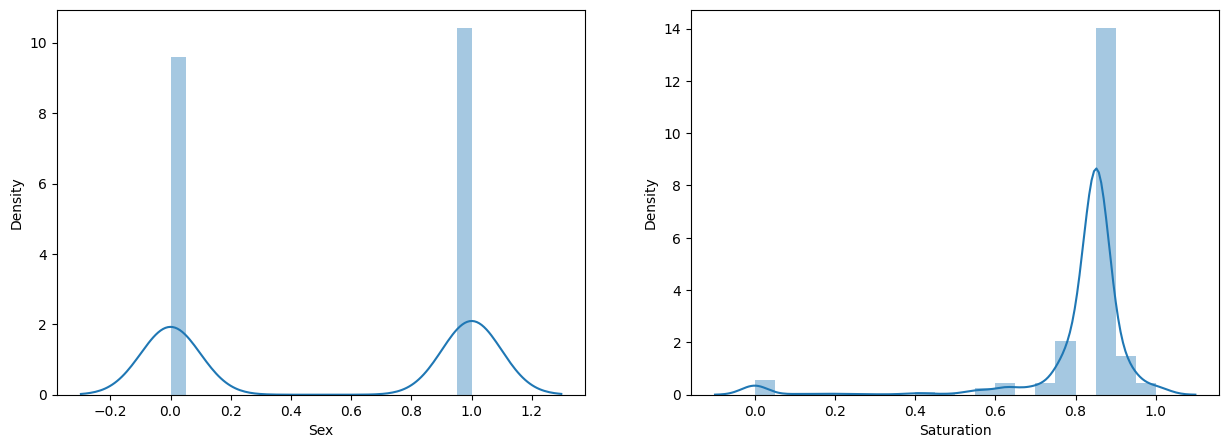

In [65]:
# select the features
shown_feature_names = ['Sex', 'Saturation']

# Plot histograms for the specified column names in 'data' using subplots
lib.plot_histogram(shown_feature_names, ready_data)

##### Countplot

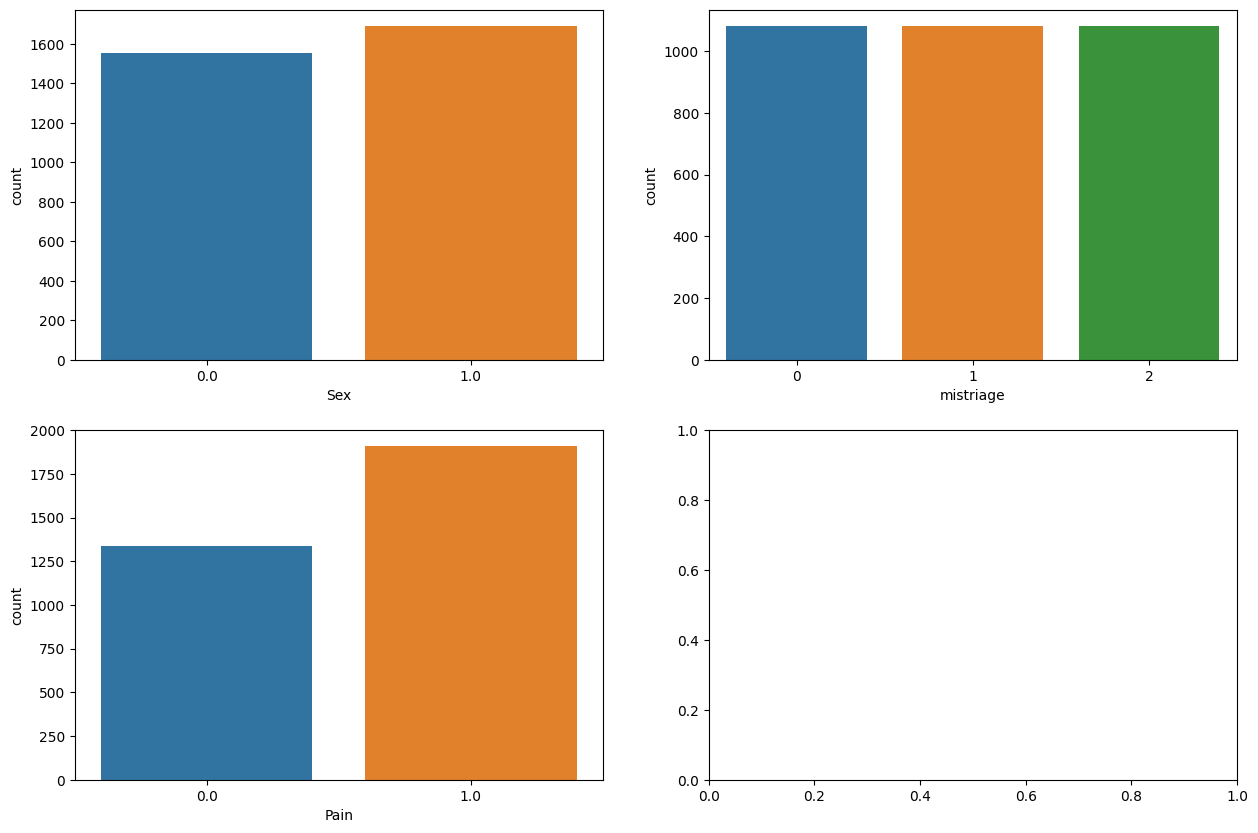

In [66]:
# select the features and plot count plots for the specified column names
names = ['Sex', 'mistriage', 'Pain']

lib.plot_countplot(names, ready_data)

<Axes: xlabel='Sex', ylabel='mistriage'>

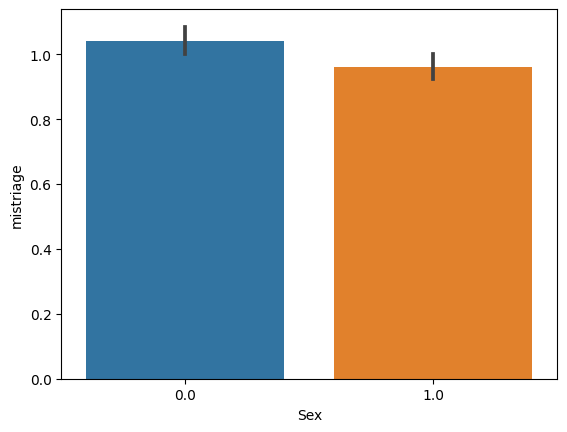

In [67]:
# Group by a categorical variable and plot aggregated values, with confidence intervals
# choose the features you want to see
x_value = 'Sex'
y_value = 'mistriage'

sns.barplot(ready_data, x=x_value, y=y_value)

##### Boxplot

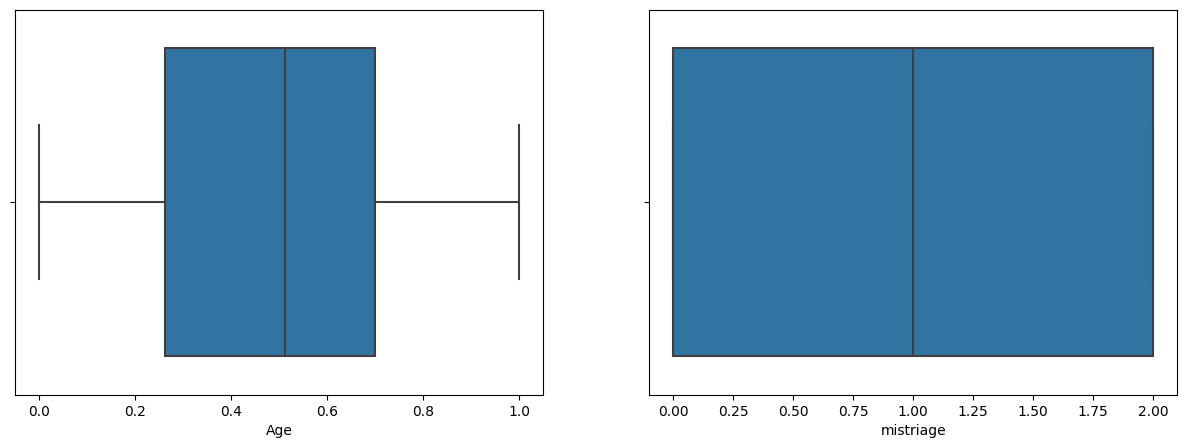

In [68]:
# select the features
names = ['Age', 'mistriage']

# Plot box plots for the specified column names in 'data' using subplots
lib.plot_boxplot(names, ready_data)

##### Scatterplot

<Axes: xlabel='RR', ylabel='mistriage'>

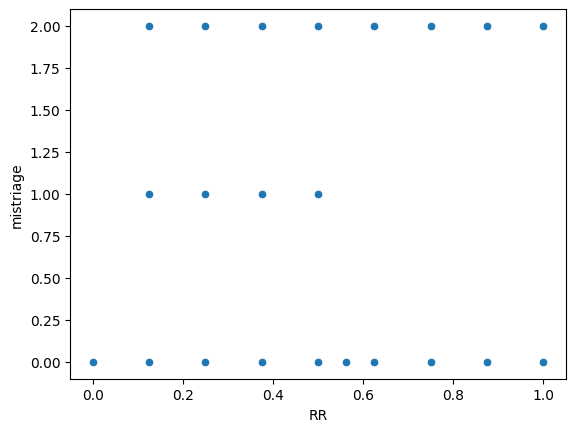

In [69]:
# Create a scatter plot to visualize the relationship between two variables.
# Seaborn is a Python data visualization library built on top of Matplotlib.
#choose the features you want to see
x_value = 'RR'
y_value = 'mistriage'

sns.scatterplot(ready_data, x=x_value, y=y_value)

<Axes: xlabel='RR', ylabel='mistriage'>

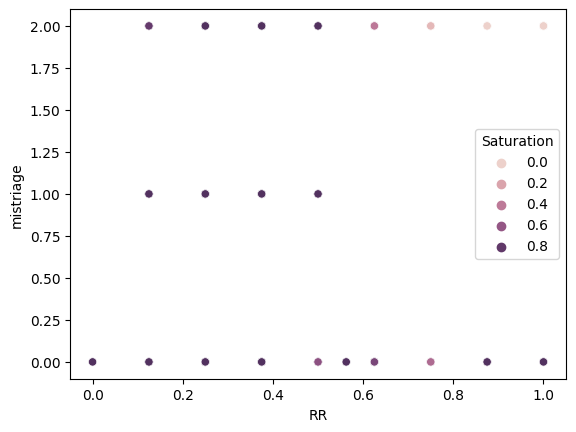

In [70]:
# take a third variable
z_value = 'Saturation'
sns.scatterplot(ready_data, x=x_value, y=y_value, hue=z_value)

##### Correlation Plot

In der Heatmap können die Zusammenhänge zwischen den einzelnen Features betrachtet werden.

<Axes: >

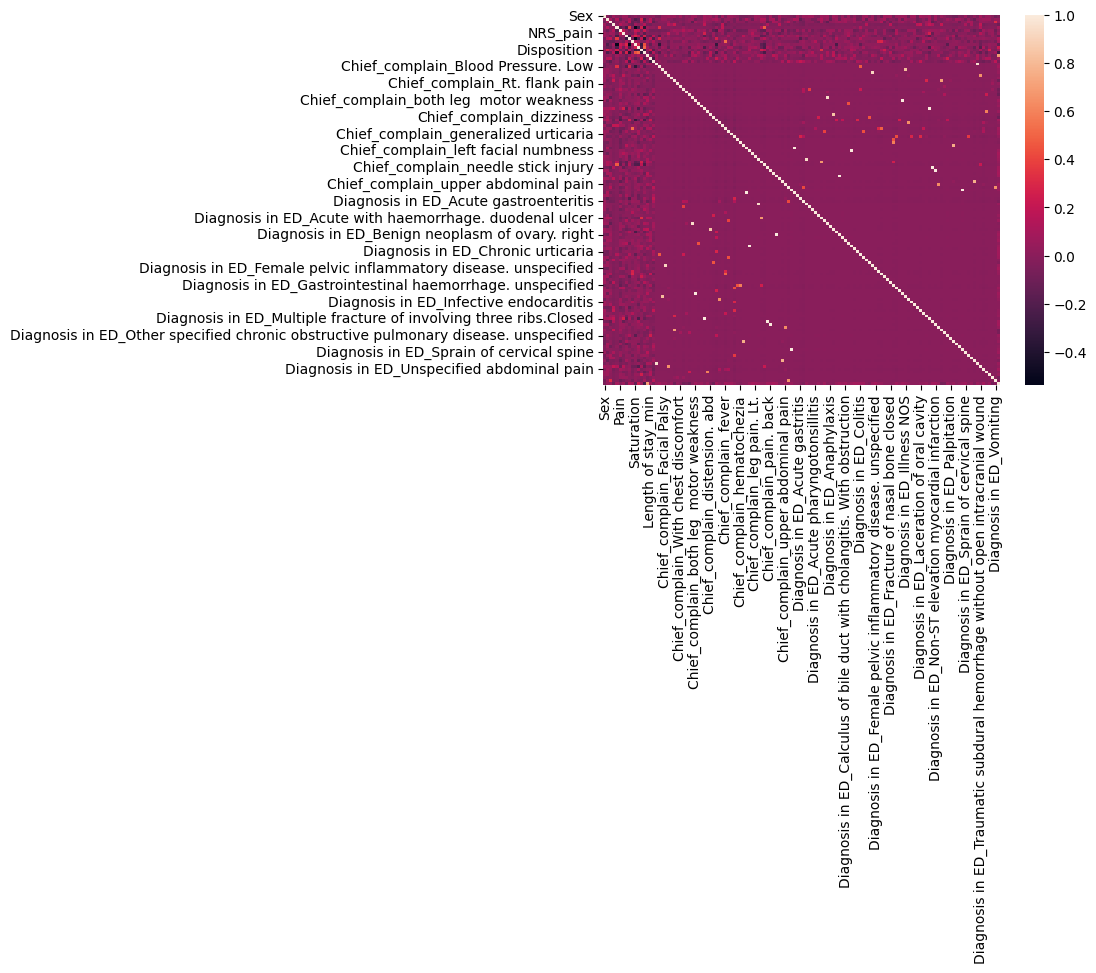

In [71]:
corr_data = ready_data.corr()
sns.heatmap(corr_data)

# Train the model

Zuerst muss der Datensatz in Trainings und in Testdaten aufgeteilt werden.

In [72]:
X = ready_data.drop(target, axis=1)
Y = ready_data[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Anschließend das Modell ausgewählt und trainiert werden.

In [73]:
# For Regression you can choose: LinearRegression(), LogisticRegression(), SVR(), DecisionTreeRegressor(), RandomForestRegressor(), KNeighborsRegressor() 
# For Classification you can choose: SVC(), DecisionTreeClassifier(), RandomForestClassifier() 

chosen_model = LinearRegression()

# if you want to use a neural network, you have to uncomment one of the following statements below:
#chosen_model = 'neural_network_regression'
chosen_model = 'neural_network_classification'

regr_or_class, model = lib.train_the_model(chosen_model, X_train, Y_train)

if(chosen_model == 'neural_network_classification'): Y_pred = np.argmax(model.predict(X_test), axis=1)
else: Y_pred = model.predict(X_test)

# Optionally, you can also access the model's coefficients and intercept
lib.show_coefficients(model)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

# Evaluation

Die Evaluierung ist wichtig, um die Qualität des Modells zu beurteilen. Dazu gibt es mehrere Möglichkeiten.

In [ ]:
# you can calculate MAE, RMSE and R_2 for Regression and Classification
# and accuracy, precision_score, recall_score, f1_score, confusion_matrix and report only for Classification

metrics = ['recall_score', 'RMSE', 'confusion_matrix']

lib.evaluate(metrics, Y_test, Y_pred)

recall_score is false metric for the chosen model
RMSE: 0.26657953288038855
confusion_matrix is false metric for the chosen model


Eine Möglichkeit ist der `Residualplot`.

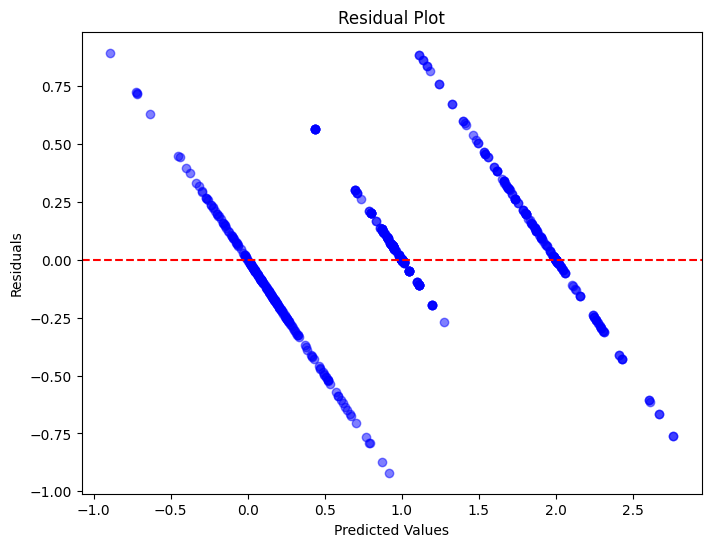

In [ ]:
residuals = Y_test.squeeze() - Y_pred.squeeze()
lib.show_residual_plot(residuals, Y_pred)